<a href="https://colab.research.google.com/github/mikalajjjj/for-fun/blob/main/AACOutcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Austin Animal Center Outcomes
- Intro to Data Mining CS 363D
- Project Group 46

Can we predict whether an animal in the Austin Animal Center will be adopted, transfered, or euthanized? Here, we perform multi-class classification on an animal's `Outcome Type`, using features from the [Austin Animal Center Intakes dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). The class label (`Outcome Type`) is from the [Animal Center Outcomes dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238); these data sets are joined on `Animal ID`.


In [1]:
%pip install pandas
%pip install scikit-learn

In [2]:
#!curl -o intakes.csv "https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD"
#!curl -o outcomes.csv "https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD"

In [3]:
import pandas as pd
import sklearn as sk

## Data Prep

- We join the 2 datasets: Intakes and Outcomes on their common column `Animal ID`.
- Some Animal IDs have multiple intakes/outcomes.
    - Number the duplicates (based on DateTime).
    - Pair intakes and outcomes based on Animal ID and Duplicate Number.

In [4]:
intakes = pd.read_csv("intakes.csv")
intakes["DateTime"] = pd.to_datetime(intakes["DateTime"])
intakes.sort_values(by="DateTime", inplace=True) # sort by date
intakes['Duplicate Number'] = intakes.groupby(['Animal ID']).cumcount() # Mark duplicate entries

# Age upon Intake: translate into Age upon Intake_NumYearsOld
def getNumYearsOld(age_str):
    months_in_a_year = 12
    weeks_in_a_year = 52.143
    days_in_a_year = 365.25
    year_idx = age_str.find("year")-1
    if(year_idx >= 0):
        return float(age_str[:year_idx])
    month_idx = age_str.find("month")-1
    if(month_idx >= 0):
        return float(age_str[:month_idx])/months_in_a_year
    weeks_idx = age_str.find("week")-1
    if(weeks_idx >= 0):
        return float(age_str[:weeks_idx])/weeks_in_a_year
    days_idx = age_str.find("day")-1
    if(days_idx >= 0):
        return float(age_str[:days_idx])/days_in_a_year
    return None

intakes["Age upon Intake"] = intakes["Age upon Intake"].apply(getNumYearsOld) # make age in terms of yearas

print(intakes.shape)
intakes.head()

(42054, 13)


,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Duplicate Number
2377,A664237,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,0.019178,Domestic Shorthair Mix,Orange/White,0
38947,A664235,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,0.019178,Domestic Shorthair Mix,Orange/White,0
34436,A664238,NaN,2013-10-01 09:33:00,October 2013,Outside Jurisdiction,Stray,Normal,Cat,Unknown,0.333333,American Shorthair Mix,Black/White,0
4781,A664234,NaN,2013-10-01 10:37:00,October 2013,5400 Jimmy Clay in Austin (TX),Stray,Injured,Dog,Intact Male,8.000000,Border Collie Mix,Black/White,0
14628,A664256,*Donnie,2013-10-01 10:59:00,October 2013,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,17.000000,Domestic Shorthair Mix,Brown Tabby/White,0


In [5]:
outcomes = pd.read_csv("outcomes.csv")
outcomes["DateTime"] = pd.to_datetime(outcomes["DateTime"])
outcomes.sort_values(by="DateTime", inplace=True)
outcomes['Duplicate Number'] = outcomes.groupby(['Animal ID']).cumcount() # Mark duplicate entries
print(outcomes.shape)
outcomes.head()


(74380, 13)


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Duplicate Number
60304,A659834,*Dudley,2013-10-01 09:31:00,Oct 2013,07/23/2013,Adoption,Foster,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black,0
49677,A664235,NaN,2013-10-01 10:39:00,Oct 2013,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0
11944,A664223,Moby,2013-10-01 11:03:00,Oct 2013,09/30/2009,Return to Owner,NaN,Dog,Neutered Male,4 years,Bulldog Mix,White,0
31824,A663646,NaN,2013-10-01 11:12:00,Oct 2013,09/22/2010,Transfer,Partner,Dog,Neutered Male,3 years,Toy Poodle Mix,White,0
28312,A663572,*Starla,2013-10-01 11:42:00,Oct 2013,09/21/2010,Adoption,NaN,Dog,Spayed Female,3 years,Anatol Shepherd Mix,White/Brown,0


In [6]:
outcomes_label = outcomes[["Animal ID", "Duplicate Number", "DateTime", "Outcome Type"]]
outcomes_label = outcomes_label.rename(columns={"DateTime": "DateTime_Outcome"})
print(outcomes_label.shape)
outcomes_label.head()

(74380, 4)


,Animal ID,Duplicate Number,DateTime_Outcome,Outcome Type
60304,A659834,0,2013-10-01 09:31:00,Adoption
49677,A664235,0,2013-10-01 10:39:00,Transfer
11944,A664223,0,2013-10-01 11:03:00,Return to Owner
31824,A663646,0,2013-10-01 11:12:00,Transfer
28312,A663572,0,2013-10-01 11:42:00,Adoption


In [7]:
raw_df = intakes.merge(outcomes_label, on=["Animal ID", "Duplicate Number"], how="inner").set_index("Animal ID")
raw_df.sort_values(by=["Animal ID", "Duplicate Number"], inplace=True)
raw_df.head()

# "Scamp" has 3 intakes/outcomes (all resulting in "Return to Owner"). They are paired together correctly!

,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Duplicate Number,DateTime_Outcome,Outcome Type
Animal ID,,,,,,,,,,,,,,
A006100,Scamp,2014-12-19 10:21:00,December 2014,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7.0,Spinone Italiano Mix,Yellow/White,0,2014-12-20 16:35:00,Return to Owner
A165752,Pep,2014-09-15 11:28:00,September 2014,Gatlin Gun Rd And Brodie in Austin (TX),Stray,Normal,Dog,Neutered Male,15.0,Lhasa Apso Mix,Brown/White,0,2014-09-15 16:35:00,Return to Owner
A251402,Amy,2017-10-22 18:41:00,October 2017,2905 French Place in Austin (TX),Stray,Normal,Dog,Spayed Female,18.0,Chihuahua Shorthair Mix,Tan,0,2017-10-23 11:32:00,Return to Owner
A254503,Daisy,2014-11-09 11:04:00,November 2014,8603 Fathom Cir in Austin (TX),Stray,Normal,Dog,Spayed Female,17.0,Labrador Retriever Mix,Tan,0,2014-11-13 11:30:00,Euthanasia
A258441,Spring,2014-11-28 12:20:00,November 2014,Austin (TX),Euthanasia Request,Sick,Cat,Spayed Female,14.0,Domestic Shorthair Mix,Gray Tabby/White,0,2014-11-28 14:27:00,Euthanasia


In [8]:
raw_df.index = raw_df.index.map(str) + "_" + raw_df['Duplicate Number'].map(str)
raw_df = raw_df.drop(columns=["DateTime_Outcome", "Duplicate Number"])
raw_df.index.name = 'Animal ID'



raw_df.to_csv("raw_full_dataset.csv")
print(raw_df.shape)
raw_df.head()

(25134, 12)


,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Type
Animal ID,,,,,,,,,,,,
A006100_0,Scamp,2014-12-19 10:21:00,December 2014,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7.0,Spinone Italiano Mix,Yellow/White,Return to Owner
A165752_0,Pep,2014-09-15 11:28:00,September 2014,Gatlin Gun Rd And Brodie in Austin (TX),Stray,Normal,Dog,Neutered Male,15.0,Lhasa Apso Mix,Brown/White,Return to Owner
A251402_0,Amy,2017-10-22 18:41:00,October 2017,2905 French Place in Austin (TX),Stray,Normal,Dog,Spayed Female,18.0,Chihuahua Shorthair Mix,Tan,Return to Owner
A254503_0,Daisy,2014-11-09 11:04:00,November 2014,8603 Fathom Cir in Austin (TX),Stray,Normal,Dog,Spayed Female,17.0,Labrador Retriever Mix,Tan,Euthanasia
A258441_0,Spring,2014-11-28 12:20:00,November 2014,Austin (TX),Euthanasia Request,Sick,Cat,Spayed Female,14.0,Domestic Shorthair Mix,Gray Tabby/White,Euthanasia


## Data Exploration

In [10]:
raw_df.describe(include="all", datetime_is_numeric=True)
# don't have a name?
# datetime as timedelta - visualize datetime

,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Type
count,17856,25134,25134,25134,25134,25134,25134,25133,25134.000000,25134,25134,25127
unique,7769,NaN,97,15342,6,11,5,5,NaN,1355,364,9
top,Max,NaN,July 2019,Austin (TX),Stray,Normal,Dog,Intact Male,NaN,Domestic Shorthair Mix,Black/White,Adoption
freq,111,NaN,420,4793,17313,21805,14611,8031,NaN,5771,2680,11523
mean,NaN,2017-06-04 08:42:06.194796032,NaN,NaN,NaN,NaN,NaN,NaN,2.091012,NaN,NaN,NaN
min,NaN,2013-10-01 08:33:00,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN
25%,NaN,2015-07-18 15:17:15,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN
50%,NaN,2017-05-13 14:37:30,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,NaN,2019-04-12 11:47:45,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
max,NaN,2021-10-19 09:29:00,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN


In [11]:
raw_df["Outcome Type"].value_counts()

Adoption           11523
Transfer            6950
Return to Owner     4534
Euthanasia          1635
Died                 204
Rto-Adopt            151
Disposal             107
Missing               18
Relocate               5
Name: Outcome Type, dtype: int64

TypeError: ignored

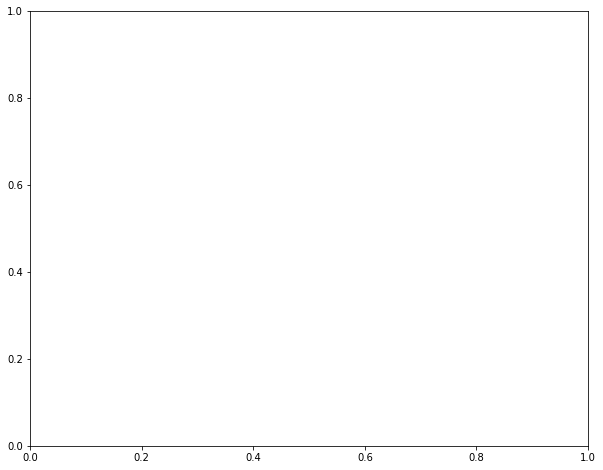

In [12]:
#plot = raw_df.loc[raw_df['Outcome Type'] == "Euthanasia"].plot.pie(y='', figsize=(5, 5))

ax = raw_df.plot.box(column="Age upon Intake", by="Outcome Type", figsize=(10, 8))


['Domestic Shorthair', 'Pit Bull', 'Labrador Retriever', 'Chihuahua Shorthair', 'German Shepherd', 'Domestic Medium Hair', 'Bat', 'Australian Cattle Dog', 'Domestic Longhair', 'Siamese', 'Dachshund']
Adoption
Other                    4174
Domestic Shorthair       3431
Pit Bull                  864
Labrador Retriever        845
Chihuahua Shorthair       714
German Shepherd           411
Domestic Medium Hair      359
Australian Cattle Dog     238
Domestic Longhair         197
Siamese                   161
Dachshund                 129
Name: Breed, dtype: int64
Died
Domestic Shorthair      101
Other                    45
Bat                      16
Chihuahua Shorthair      13
Domestic Medium Hair     12
Pit Bull                  5
Labrador Retriever        5
Siamese                   3
Domestic Longhair         2
German Shepherd           2
Name: Breed, dtype: int64
Disposal
Bat                     53
Other                   34
Domestic Shorthair      14
Domestic Medium Hair     2
Domesti

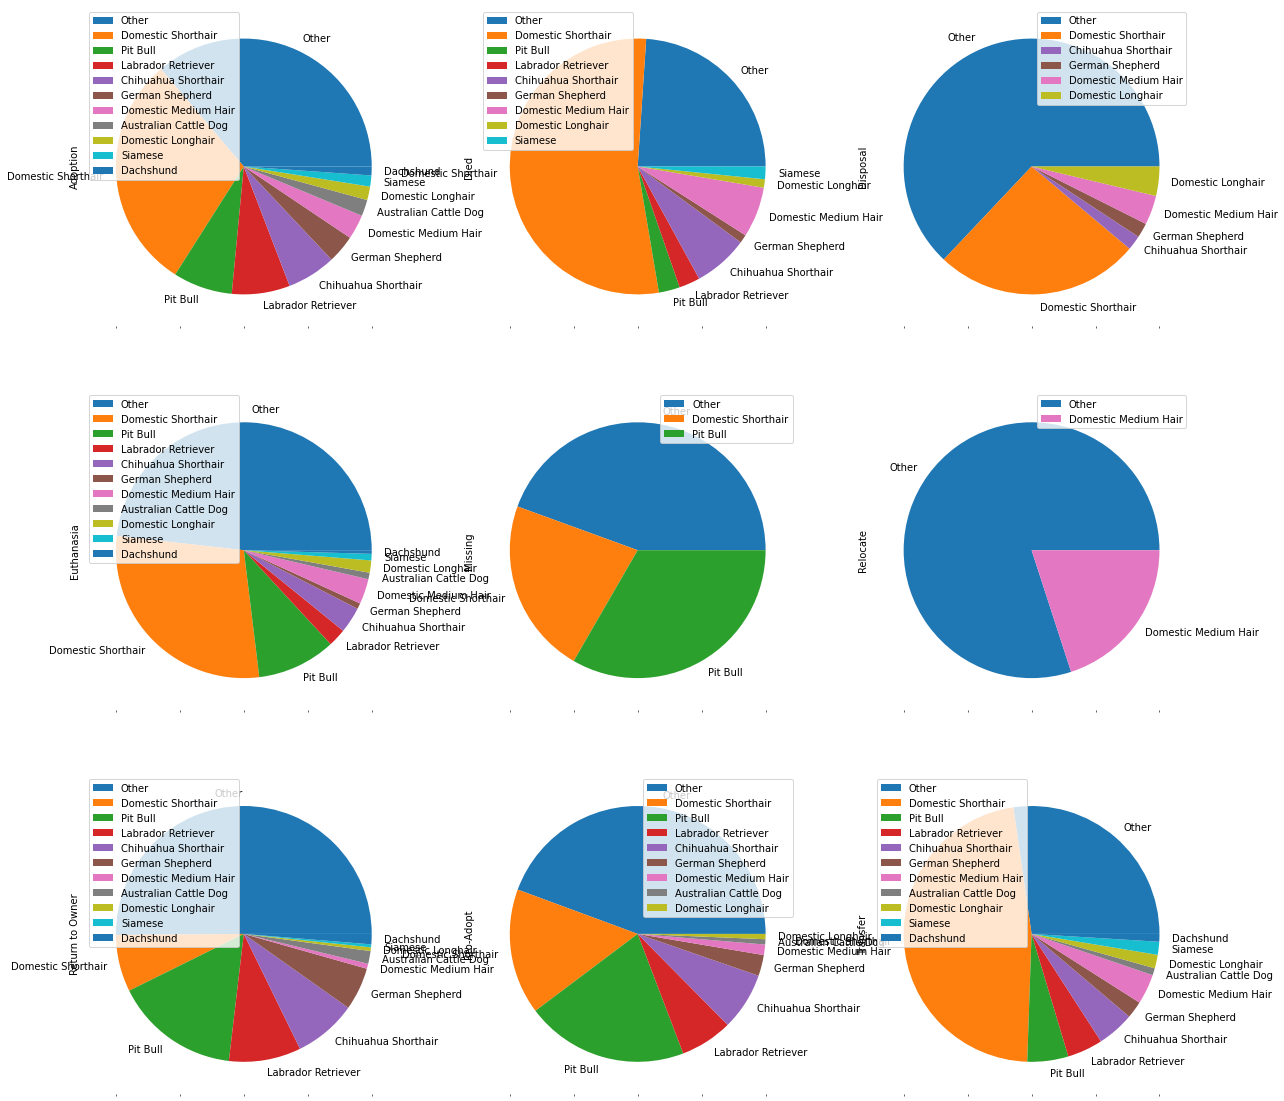

In [13]:
from matplotlib import pyplot as plt

def cumulatively_categorize(df, columns, threshold_freq = .9, num_categories = None):
    '''
    Only keep categories needed sum to threshold_freq, move rest into "Other".
    Or, keep top threshold_num categories, and move rest into "Other".
    '''
    df = df.copy()
    threshold = threshold_freq*len(df)
    for column_name in columns:

        counts = df[column_name].value_counts()
        
        s = 0
        to_keep = []
        for value, count in counts.iteritems():
            s += count
            to_keep.append(value)

            if(num_categories is not None):
                # based on num of categories
                if(len(to_keep) > num_categories):
                    break
            else:
                # based on frequency
                if(s > threshold):
                    break

        print(to_keep)
        df[column_name]=df[column_name].apply(lambda x: x if x in to_keep else 'Other')
    return df

def show_pie_chart(df, categorical_var, label = "Outcome Type"):
    gb = df.groupby([label])
    outcome_groups = [gb.get_group(x) for x in gb.groups]
    outcome_labels = [x for x in gb.groups]

    pie_chart_df = pd.DataFrame()

    for i, outcome_df in enumerate(outcome_groups):
        val_counts = outcome_df[categorical_var].value_counts()
        print(outcome_labels[i])
        print(val_counts)
        pie_chart_df[outcome_labels[i]] = val_counts # this logic is wrong: where does "Bat" go?
        # Idea: insert empty column with every Breed category, then drop it at the end.

    pie_chart_df

    print(pie_chart_df)

    pie_chart_df.plot.pie(subplots=True, layout=(3,3), figsize=(20, 20)) # TODO: fix the size, make pretty

df = raw_df.copy()
df['Breed'] = df['Breed'].apply(lambda str: str.replace(" Mix", "")) # remove Mix

show_pie_chart(cumulatively_categorize(df, columns=["Breed"], num_categories=10), "Breed")

In [ ]:
df = cumulatively_categorize(df, columns=["Breed"], num_categories = 10)
show_pie_chart(raw_df, "Intake Condition")

## Feature Engineering

In [24]:
df = raw_df.copy()
    
def one_hot_encode(df, columns):
    '''
    Take a categorical variable, one-hot encode, and join back into dataframe.
    '''
    for column_name in columns:
        one_hot_encoded = pd.get_dummies(df[column_name], prefix=column_name)
        df = df.drop(column_name, axis='columns')
        df = df.join(one_hot_encoded, on="Animal ID")
    return df


# Breed: bin less common breeds into "Other", one-hot encode
df['Breed'] = df['Breed'].apply(lambda str: str.replace(" Mix", "")) # remove Mix
df = cumulatively_categorize(df, columns=["Breed"], num_categories = 10)
df = one_hot_encode(df, columns=["Breed"])

# Outcome Type: collect Adoption, Return to Owner, Rto-Adopt
def collectAdoption(outcome):
    if(outcome in ["Adoption", "Return to Owner", "Rto-Adopt"]):
        return ("Adoption/RTO")
    else:
        return outcome
df["Outcome Type"] = df["Outcome Type"].apply(collectAdoption)
df = cumulatively_categorize(df, columns=["Outcome Type"],num_categories=4)
df = one_hot_encode(df, columns=["Outcome Type"])

# To drop
to_drop = ["Name", "MonthYear", "Color", "Found Location", "DateTime"]
df = df.drop(columns=to_drop)

# To one-hot encode
to_one_hot_encode = ["Intake Type", "Intake Condition", "Animal Type", "Sex upon Intake"] # experiment
df = cumulatively_categorize(df, columns=to_one_hot_encode)
df = one_hot_encode(df, columns=to_one_hot_encode)


['Domestic Shorthair', 'Pit Bull', 'Labrador Retriever', 'Chihuahua Shorthair', 'German Shepherd', 'Domestic Medium Hair', 'Bat', 'Australian Cattle Dog', 'Domestic Longhair', 'Siamese', 'Dachshund']
['Adoption/RTO', 'Transfer', 'Euthanasia', 'Died', 'Disposal']
['Stray', 'Owner Surrender', 'Public Assist']
['Normal', 'Injured']
['Dog', 'Cat']
['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female']


In [25]:
df.head()

,Age upon Intake,Breed_Australian Cattle Dog,Breed_Bat,Breed_Chihuahua Shorthair,Breed_Dachshund,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd,Breed_Labrador Retriever,...,Intake Condition_Normal,Intake Condition_Other,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Intake_Intact Female,Sex upon Intake_Intact Male,Sex upon Intake_Neutered Male,Sex upon Intake_Other,Sex upon Intake_Spayed Female
Animal ID,,,,,,,,,,,,,,,,,,,,,
A006100_0,7.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
A165752_0,15.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
A251402_0,18.0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
A254503_0,17.0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
A258441_0,14.0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1


In [16]:
print(df.columns)

Index(['Age upon Intake', 'Breed_Australian Cattle Dog', 'Breed_Bat',
       'Breed_Chihuahua Shorthair', 'Breed_Dachshund',
       'Breed_Domestic Longhair', 'Breed_Domestic Medium Hair',
       'Breed_Domestic Shorthair', 'Breed_German Shepherd',
       'Breed_Labrador Retriever', 'Breed_Other', 'Breed_Pit Bull',
       'Breed_Siamese', 'Outcome Type_Adoption/RTO', 'Outcome Type_Died',
       'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
       'Outcome Type_Other', 'Outcome Type_Transfer', 'Intake Type_Other',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Intake Condition_Injured',
       'Intake Condition_Normal', 'Intake Condition_Other', 'Animal Type_Cat',
       'Animal Type_Dog', 'Animal Type_Other', 'Sex upon Intake_Intact Female',
       'Sex upon Intake_Intact Male', 'Sex upon Intake_Neutered Male',
       'Sex upon Intake_Other', 'Sex upon Intake_Spayed Female'],
      dtype='object')


In [43]:
# labels_names = ['Outcome Type_Adoption', 'Outcome Type_Died',
#        'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
#        'Outcome Type_Missing', 'Outcome Type_Relocate',
#        'Outcome Type_Return to Owner', 'Outcome Type_Rto-Adopt',
#        'Outcome Type_Transfer',]

labels_names = ['Outcome Type_Died',
       'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
       'Outcome Type_Other', 'Outcome Type_Transfer', 'Outcome Type_Adoption/RTO']
labels = df[labels_names]
features = df.drop(columns=labels_names)
print("labels:",labels.shape)
print("features:",features.shape)
features.head()

labels: (25134, 6)
features: (25134, 28)


,Age upon Intake,Breed_Australian Cattle Dog,Breed_Bat,Breed_Chihuahua Shorthair,Breed_Dachshund,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd,Breed_Labrador Retriever,...,Intake Condition_Normal,Intake Condition_Other,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Intake_Intact Female,Sex upon Intake_Intact Male,Sex upon Intake_Neutered Male,Sex upon Intake_Other,Sex upon Intake_Spayed Female
Animal ID,,,,,,,,,,,,,,,,,,,,,
A006100_0,7.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
A165752_0,15.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
A251402_0,18.0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
A254503_0,17.0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
A258441_0,14.0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1


## Data Analysis

### Test/Train Split

In [44]:
from sklearn import *
from sklearn.model_selection import train_test_split
train_size = int(.8*len(features))
test_size = len(features) - train_size
X_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, train_size=train_size, shuffle=False)
print("length of train set: ")
print(len(y_train))
print("length of test set: ")
print(len(y_test))

length of train set: 
20107
length of test set: 
5027


In [45]:
from sklearn import *
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
clfO = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clfO = clfO.fit(X_train, y_train)
y_predict = clfO.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print(acc) # need to see precision

0.6463099263974538


In [46]:
print(tree.export_text(clfO, feature_names=list(features.columns)))

|--- Intake Type_Other <= 0.50
|   |--- Animal Type_Dog <= 0.50
|   |   |--- Sex upon Intake_Other <= 0.50
|   |   |   |--- Intake Condition_Normal <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- Intake Condition_Normal >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Sex upon Intake_Other >  0.50
|   |   |   |--- Age upon Intake <= 0.07
|   |   |   |   |--- class: 3
|   |   |   |--- Age upon Intake >  0.07
|   |   |   |   |--- class: 3
|   |--- Animal Type_Dog >  0.50
|   |   |--- Intake Condition_Normal <= 0.50
|   |   |   |--- Age upon Intake <= 0.54
|   |   |   |   |--- class: 3
|   |   |   |--- Age upon Intake >  0.54
|   |   |   |   |--- class: 1
|   |   |--- Intake Condition_Normal >  0.50
|   |   |   |--- Age upon Intake <= 0.09
|   |   |   |   |--- class: 1
|   |   |   |--- Age upon Intake >  0.09
|   |   |   |   |--- class: 1
|--- Intake Type_Other >  0.50
|   |--- Breed_Bat <= 0.50
|   |   |--- Intake Condition_Normal <= 0.50
|   |   |   |--- Breed_Other <= 0.50
|  

In [47]:
# Use `sklearn.tree.DecisionTreeClassifier` to fit a decision tree classifier on the training set. Use entropy as the split criterion.
from sklearn import *

clf = tree.DecisionTreeClassifier(criterion="entropy")
param_grid={
    "max_depth": [5,10],
    "min_samples_leaf": [5,10],
    "max_features": [5,10],
}
clf = model_selection.GridSearchCV(clf,param_grid=param_grid,cv=5,scoring="accuracy")
clf.fit(X_train,y_train)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 10}
0.7230824719204781


In [54]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
labels = df.iloc[:,13]
clf = GaussianNB()
accs=np.mean(model_selection.cross_val_score(clf, X=features, y=labels,cv=10))
print("Accuracy NB: ")
print(accs.mean())
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = cross_val_predict(clf, features, labels, cv=10)
conf_mat = confusion_matrix(labels, y_pred)
print("Confusion Matrix: ")
print(conf_mat)
print("Classification Report: ")
print(classification_report(labels, y_pred))


0.730444963833254
[[ 3087  5839]
 [  936 15272]]
              precision    recall  f1-score   support

           0       0.77      0.35      0.48      8926
           1       0.72      0.94      0.82     16208

    accuracy                           0.73     25134
   macro avg       0.75      0.64      0.65     25134
weighted avg       0.74      0.73      0.70     25134



In [52]:
# knn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
pca = PCA()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])
res = cross_val_score(pipe, features, labels, cv=5)
print(res.mean())

0.6827791604602951


## Results